# Summary
- Analysis of fine-tuned models

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from ipywidgets import FloatSlider, interactive
import sys
sys.path.append('..')
from var import fname2mname, network2pair, network_sort_key

In [5]:
# loading in them all made my machine run out of memory
method_l = [
     "maxcorr", 
     "mincorr", 
     "maxlinreg", 
     "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [6]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/belinkov/contextual-corr-analysis/repr_fine_results1_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["cca"]["corrs"]]
network_l = sorted(network_l, key=network_sort_key)

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["cca"]["corrs"][network].values()))) # god this is a hack

In [7]:
network_l

['bert_base_uncased-ptb_pos_dev.hdf5_0',
 'bert_base_uncased-ptb_pos_dev.hdf5_1',
 'bert_base_uncased-ptb_pos_dev.hdf5_2',
 'bert_base_uncased-ptb_pos_dev.hdf5_3',
 'bert_base_uncased-ptb_pos_dev.hdf5_4',
 'bert_base_uncased-ptb_pos_dev.hdf5_5',
 'bert_base_uncased-ptb_pos_dev.hdf5_6',
 'bert_base_uncased-ptb_pos_dev.hdf5_7',
 'bert_base_uncased-ptb_pos_dev.hdf5_8',
 'bert_base_uncased-ptb_pos_dev.hdf5_9',
 'bert_base_uncased-ptb_pos_dev.hdf5_10',
 'bert_base_uncased-ptb_pos_dev.hdf5_11',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_0',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_1',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_2',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_3',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_4',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_5',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_6',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_7',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_8',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_9',
 'bert_base_uncased-ptb_pos_dev_mnli.hdf5_10',

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [8]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [9]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [10]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [11]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_base_uncased-ptb_pos_dev.hdf5_0
            mincorr  minlinreg  maxlinreg   maxcorr
mincorr    1.000000   0.413221   0.195996  0.214047
minlinreg  0.413221   1.000000   0.313669  0.338987
maxlinreg  0.195996   0.313669   1.000000  0.835308
maxcorr    0.214047   0.338987   0.835308  1.000000
bert_base_uncased-ptb_pos_dev.hdf5_1
            mincorr  minlinreg  maxlinreg   maxcorr
mincorr    1.000000   0.421783  -0.150774 -0.177983
minlinreg  0.421783   1.000000   0.154694  0.070034
maxlinreg -0.150774   0.154694   1.000000  0.831154
maxcorr   -0.177983   0.070034   0.831154  1.000000
bert_base_uncased-ptb_pos_dev.hdf5_2
            mincorr  minlinreg  maxlinreg   maxcorr
mincorr    1.000000   0.404584  -0.158037 -0.161110
minlinreg  0.404584   1.000000   0.225499  0.182813
maxlinreg -0.158037   0.225499   1.000000  0.932017
maxcorr   -0.161110   0.182813   0.932017  1.000000
bert_base_uncased-ptb_pos_dev.hdf5_3
            mincorr  minlinreg  maxlinreg   maxcorr
mincorr    1.000000 

### Distributions

In [12]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_base_uncased-ptb_pos_dev.hdf5_0:

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    762
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        5
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.214055  0.090236
min  0.214055  1.000000  0.062222
med  0.090236  0.062222  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.313684  0.271137
min  0.313684  1.000000  0.654566
med  0.271137  0.654566  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.313684  0.271137



maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_7    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    767
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.667757  0.977794
min  0.667757  1.000000  0.707989
med  0.977794  0.707989  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_7    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    767
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.667757  0.977794
min  0.667757  1.000000  0.707989
med  0.977794  0.707989  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_7          445
bert_base_uncased-ptb_pos_dev.hdf5_5          322
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_6      1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    766
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      2
dtype

          max       min       med
max  1.000000  0.196956  0.084186
min  0.196956  1.000000  0.067905
med  0.084186  0.067905  1.000000


bert_base_uncased-ptb_pos_dev_mnli.hdf5_1:

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2     437
bert_base_uncased-ptb_pos_dev.hdf5_1          316
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1      6
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1       5
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0       3
bert_base_uncased-ptb_pos_dev_qqp.hdf5_1        1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.053983  0.857672
min -0.053983  1.000000 -0.036150
med  0.857672 -0.036150  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2    631
bert_base_uncased-ptb_pos_dev.hdf5_1         137
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  

bert_base_uncased-ptb_pos_dev_mnli.hdf5_8    468
bert_base_uncased-ptb_pos_dev_mnli.hdf5_6    300
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    745
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        6
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0         6
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0       5
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0        2
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1       1
bert_base_uncased-ptb_pos_dev_qqp.hdf5_10        1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1        1
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.029732  0.822786
min  0.029732  1.000000 -0.058585
med  0.822786 -0.058585  1.000000


bert_base_uncased-ptb_pos_dev_mnli.hdf5_8:

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_7    586
bert_base_uncased-ptb_pos_dev_mnli.hdf5_9    182
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    723
bert_base_uncased-

          max       min       med
max  1.000000  0.110344  0.287336
min  0.110344  1.000000  0.448174
med  0.287336  0.448174  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_10    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      330
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0      215
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0       172
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11     32
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      19
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.238643  0.485405
min  0.238643  1.000000  0.695050
med  0.485405  0.695050  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_10    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      330
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0      215
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0       172
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11     32
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      19

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    765
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      2
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.053367  0.914367
min  0.053367  1.000000 -0.004289
med  0.914367 -0.004289  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_qnli.hdf5_7    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    766
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.598836  0.958497
min  0.598836  1.000000  0.676464
med  0.958497  0.676464  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_qnli.hdf5_7    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    766
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.598836  0.958497
min  0.598836  1.000000  0.67646

bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.190222  0.045148
min  0.190222  1.000000  0.065090
med  0.045148  0.065090  1.000000


bert_base_uncased-ptb_pos_dev_qqp.hdf5_1:

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_1          767
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_1      1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.101103  0.683490
min -0.101103  1.000000 -0.105151
med  0.683490 -0.105151  1.000000

minlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_1    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.208862  0.829960
min  0.208862  1.000000  0.424115
med  0.829960  0.424115  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_1    768
dtype: int64



bert_base_uncased-ptb_pos_dev_qqp.hdf5_8    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    767
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.681445  0.946148
min  0.681445  1.000000  0.760881
med  0.946148  0.760881  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_8    553
bert_base_uncased-ptb_pos_dev_qqp.hdf5_6    215
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    765
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10      2
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.145938  0.928058
min  0.145938  1.000000  0.127550
med  0.928058  0.127550  1.000000


bert_base_uncased-ptb_pos_dev_qqp.hdf5_8:

mincorr

maxcounts
bert_base_uncased-ptb_pos_dev_qqp.hdf5_7    457
bert_base_uncased-ptb_pos_dev_qqp.hdf5_9    311
dtype: int64

mincounts
bert_base_uncased-ptb_p

bert_base_uncased-ptb_pos_dev.hdf5_1    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.127617  0.811464
min  0.127617  1.000000  0.435034
med  0.811464  0.435034  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_1    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.127617  0.811464
min  0.127617  1.000000  0.435034
med  0.811464  0.435034  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev.hdf5_1         766
bert_base_uncased-ptb_pos_dev_qqp.hdf5_1       1
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1      1
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    753
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11       8
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11        4
bert_base_uncased-ptb_pos_dev_qnli.hdf5_7        1
bert_base_uncased-p


maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_7    744
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_9     24
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_11     192
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_11    191
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0      107
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0        51
bert_base_uncased-ptb_pos_dev_qqp.hdf5_11       41
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0       40
bert_base_uncased-ptb_pos_dev_mnli.hdf5_10      33
bert_base_uncased-ptb_pos_dev_mnli.hdf5_1       20
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      15
bert_base_uncased-ptb_pos_dev.hdf5_0            12
bert_base_uncased-ptb_pos_dev_qnli.hdf5_11      11
bert_base_uncased-ptb_pos_dev_qqp.hdf5_2        10
bert_base_uncased-ptb_pos_dev_mnli.hdf5_2        8
bert_base_uncased-ptb_pos_dev_mnli.hdf5_3        8
bert_base_uncased-ptb_pos_dev_qnli.hdf5_1        7
bert_base_uncased-ptb_pos_dev_qqp.hdf5_3         5
bert_base_uncased-ptb_pos_dev_qnli.hdf5_2        


maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0     670
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0      54
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0       42
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.565584  0.549912
min  0.565584  1.000000  0.972990
med  0.549912  0.972990  1.000000

maxlinreg

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10    768
dtype: int64

mincounts
bert_base_uncased-ptb_pos_dev_mnli.hdf5_0     670
bert_base_uncased-ptb_pos_dev_qnli.hdf5_0      54
bert_base_uncased-ptb_pos_dev_qqp.hdf5_0       42
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_0      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.565584  0.549912
min  0.565584  1.000000  0.972990
med  0.549912  0.972990  1.000000

maxcorr

maxcounts
bert_base_uncased-ptb_pos_dev_sst-2.hdf5_10    768
dtype: int64

mincou

# LinCKA

In [13]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(network_l)
lincka_df = lincka_df.reindex(lincka_df.columns)

In [14]:
# network = "elmo_original_0"
# lincka_df.sort_values(by=network)[network]

# RBFCKA

In [15]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [16]:
# rbfcka_df

In [17]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [18]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [19]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(network_l)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)

pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(network_l)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)

sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(network_l)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)

pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(network_l)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)

pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(network_l)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)

In [20]:
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [21]:
# network = "elmo_original_0"
# sv_sim_df.sort_values(by=network)[network]

### PWCCA

In [22]:
# network = "elmo_original_0"
# pw_sim_df.sort_values(by=network)[network]

# Heatmaps

In [23]:
plt.rcParams["figure.figsize"] = (20,15)

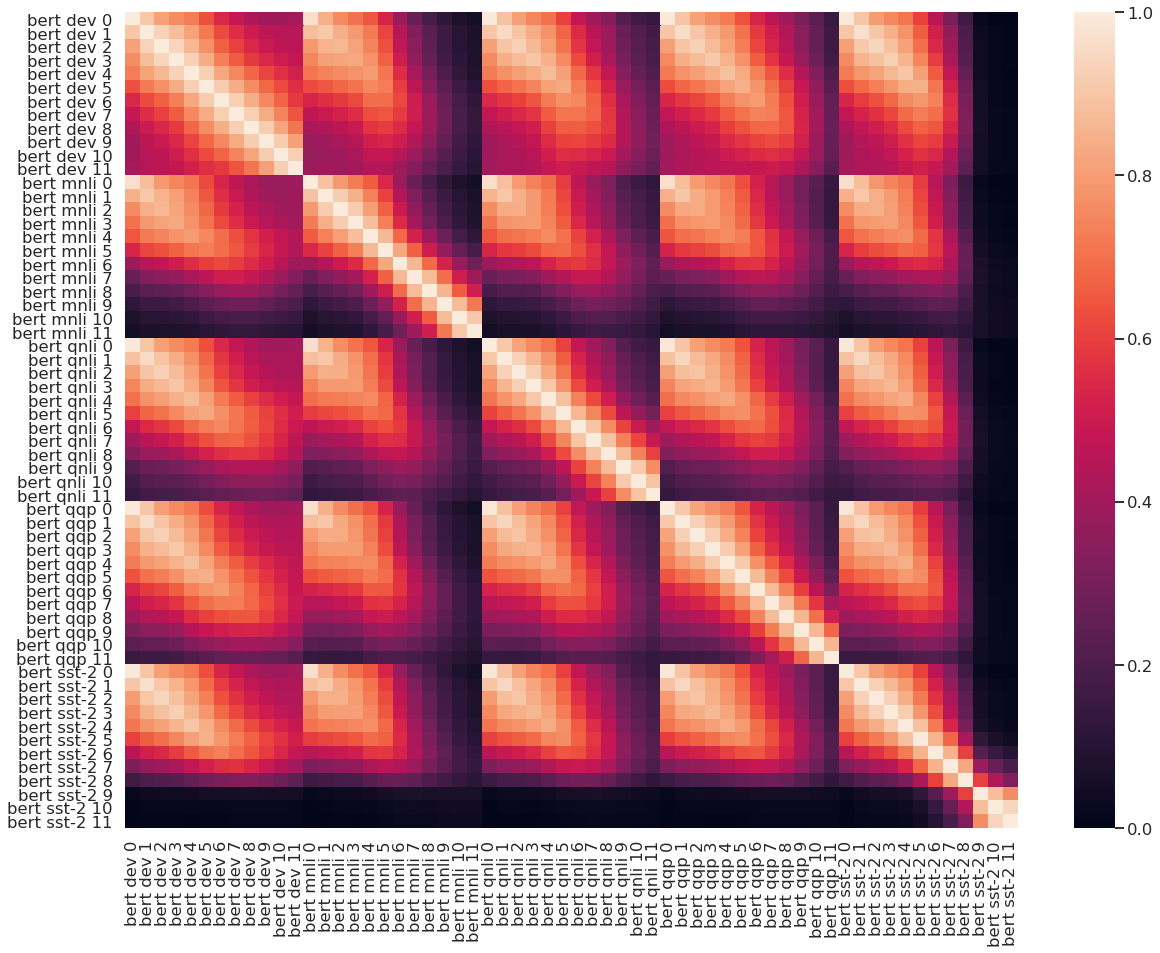

In [42]:
# lincka
short_labels = [label.split('_')[0] + ' ' + label.split('_')[-2].split('.')[0] + ' ' + label.split('_')[-1] for label in network_l]
g = sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1, xticklabels=short_labels, yticklabels=short_labels)
g.get_figure().savefig('bert-lincka-heatmap-finetuned.pdf')

In [25]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

In [26]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_fine_pw1_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [27]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_fine_sv1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [28]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_fine_maxmincorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [29]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_fine_linregcorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [30]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [31]:
# # comparing models
# # use lincka
# model1 = "xlnet"
# model2 = "xlnet"
# cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
# rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

In [32]:
# df = lincka_df.loc[rows, cols]

# sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
# plt.xlabel(model1)
# plt.ylabel(model2)
# plt.show()

# Localized vs distributed


In [33]:
locl_meth = "maxcorr"
dist_meth = "cca"

# Localized and distributed dataframes
locl_df = pd.DataFrame(res_d[locl_meth]['similarities'])
locl_df = locl_df.reindex(locl_df.columns)

dist_df = pd.DataFrame(res_d[dist_meth]['sv_similarities'])
dist_df = dist_df.reindex(dist_df.columns)

# Localization and distributivity statistics
locl_ser = locl_df.mean(axis=1)
locl_ser = (locl_ser - locl_ser.mean()) / locl_ser.std()

dist_ser = dist_df.mean(axis=1)
dist_ser = (dist_ser - dist_ser.mean()) / dist_ser.std()

# diff_ser
diff_ser = locl_ser - dist_ser

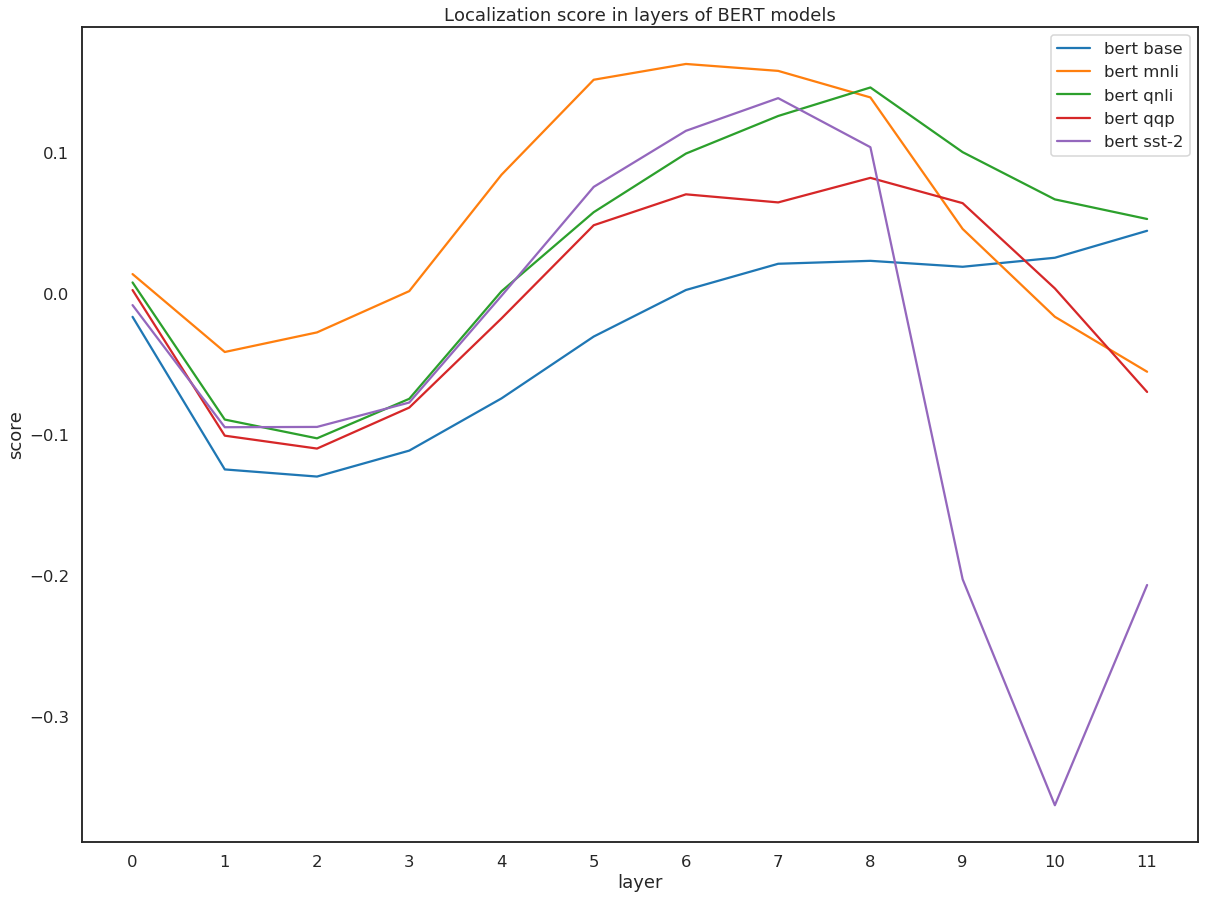

In [38]:
diff_df = pd.DataFrame(diff_ser, columns=['score'])
x = [network_sort_key(layer) for layer in diff_df.index.values]
models, layers = list(zip(*x))
models = [model.split('_')[0] + ' ' + model.split('_')[-1].split('.')[0] for model in models]
models = ['bert base' if model == 'bert dev' else model for model in models]
# print(models)
# print(layers)
diff_df['layer'] = layers
diff_df['model'] = models
# diff_df.head()
g = sns.lineplot(data=diff_df, x='layer', y='score', hue='model')
g.set_xticks(range(12))
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[1:], labels=labels[1:])
g.set_title('Localization score in layers of BERT models')
g.get_figure().savefig('bert-loc-score.png')

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(diff_ser.sort_values())

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(locl_ser.sort_values())

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(dist_ser.sort_values())